<a href="https://colab.research.google.com/github/mahdavipanah/IoT-Colab/blob/main/IoT_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the paper https://www.sciencedirect.com/science/article/pii/S0959652621016267

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
pip install dataframe-image

In [53]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import dataframe_image as dfi
import imageio
from pathlib import Path
import os

%load_ext google.colab.data_table

from google.colab import data_table
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:.4f}"

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


In [54]:
#@title #Parameters

#@markdown Prior knowledge for the probability of the event occurrence:
PE = 0.7#@param {type:"number"}

#@markdown Selection ratio in the list of nodes
S = 100#@param {type:"integer"}
K = 10#@param {type:"integer"}

#@markdown Number of trusted nodes:
TRUSTED_NODES_COUNT = 90#@param {type:"integer"}

#@markdown Trusted nodes probability range (inclusive):
P_START = 0.6#@param {type:"number"}
P_END = 0.8#@param {type:"number"}

#@markdown Malicious nodes probability range (inclusive)
MALICIOUS_P_START = 0.3#@param {type:"number"}
MALICIOUS_P_END = 0.39#@param {type:"number"}

#@markdown Security level for calculating ideal value for Nash EQ:
S_STAR_DELTA = 2#@param {type:"number"}

#@markdown Default trust value:
DEFAULT_TRUST = 0.5#@param {type:"number"}

#@markdown Punishment and reward for trust of nodes based on Nash EQ:
TRUST_PUNISH_VALUE = 0.01#@param {type:"number"}

#@markdown Maximum and minimum for trust values:
TRUST_MAX = 0.9#@param {type:"number"}
TRUST_MIN = 0.1#@param {type:"number"}

#@markdown Number of iterations:
ITERATIONS_COUNT = 50#@param {type:"integer"}

#@markdown Indicates weather the code must generate plot image files or not:
GENERATE_PLOT_PNG = True #@param {type:"boolean"}

#@markdown Folder for saving plog pngs (old png files will be removed):
PLOT_PNG_FOLDER = "/content/drive/MyDrive/iot-project/plot-png/" #@param {type:"string"}

#@markdown Trust upper and lower bound for plots:
UPPER_BOUND = 0.8#@param {type:"number"}
LOWER_BOUND = 0.3#@param {type:"number"}

,probability,trust,average,cost1,cost2,utility,s*
0,0.792207,0.90,0.599530,0.037125,0.078169,0.115294,0.556075
1,0.384307,0.45,0.644852,0.067884,0.117082,0.184965,0.685666
2,0.639643,0.90,0.616481,0.000536,0.016135,0.016671,0.564551
3,0.630712,0.90,0.617474,0.000175,0.013946,0.014121,0.565047
4,0.678507,0.90,0.612163,0.004401,0.027518,0.031920,0.562392
...,...,...,...,...,...,...,...
95,0.681937,0.90,0.696407,0.000209,0.030859,0.031069,0.777006
96,0.641098,0.90,0.700945,0.003582,0.046876,0.050457,0.779275
97,0.786630,0.90,0.684775,0.010374,0.005038,0.015412,0.771190
98,0.731737,0.90,0.690874,0.001670,0.015843,0.017513,0.774240


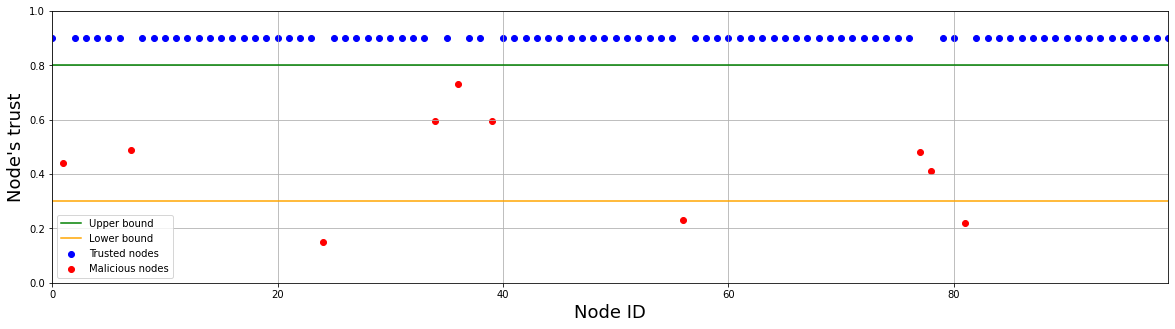

In [57]:
plt.figure(figsize=(20, 5))

rng = np.random.default_rng()

malicious_indices = rng.choice(S, size=S - TRUSTED_NODES_COUNT, replace=False)
trusted_indices = np.delete(np.arange(S), malicious_indices)

data_frame = pd.DataFrame()

if GENERATE_PLOT_PNG:
  # remove old pngs plots
  [f.unlink() for f in Path(PLOT_PNG_FOLDER).glob("*.png") if f.is_file()]

plot_list = np.array([])

for iter in np.arange(ITERATIONS_COUNT):
  # trusted nodes
  trusted_nodes = rng.uniform(
    P_START,
    P_END,
    TRUSTED_NODES_COUNT
  )
  # malicious nodes 
  malicious_nodes = rng.uniform(
    MALICIOUS_P_START,
    MALICIOUS_P_END,
    S - TRUSTED_NODES_COUNT,
  )

  nodes = np.array([])
  for i in np.arange(S):
    elem = None

    if np.any(np.isin(malicious_indices, i)):
      elem, malicious_nodes = malicious_nodes[0], np.delete(malicious_nodes, 0)
    else:
      elem, trusted_nodes = trusted_nodes[0], np.delete(trusted_nodes, 0)

    nodes = np.append(nodes, elem)

  data_frame['probability'] = nodes

  if iter == 0:
    data_frame['trust'] = DEFAULT_TRUST
  
  # generate plot image files
  if GENERATE_PLOT_PNG:
    plt.clf()
    plt.scatter(
        trusted_indices,
        data_frame.loc[trusted_indices, 'trust'].values,
        color="blue",
        label= 'Trusted nodes',
    )
    plt.scatter(
        malicious_indices,
        data_frame.loc[malicious_indices, 'trust'].values,
        color="red",
        label= 'Malicious nodes',
    )
    plt.ylim(0, 1)
    plt.xlim(0, S - 1)
    plt.xlabel('Node ID', fontsize=18)
    plt.ylabel("Node's trust", fontsize=18)
    plt.axhline(UPPER_BOUND, color="green", label="Upper bound")
    plt.axhline(LOWER_BOUND, color="orange", label="Lower bound")
    plt.grid()
    png_filename = os.path.join(PLOT_PNG_FOLDER, str(iter) + '.png')
    plt.legend()
    plt.savefig(png_filename)
    plot_list = np.append(plot_list, png_filename)

  for n in np.arange(S//K):
    # indecies of the n-th E-Sensor
    sensor_indices = np.arange(n * K, n * K + K)
    
    for i in sensor_indices:
      i_prob = data_frame.at[i, 'probability']

      # indices of other nodes of the sensor
      others_indices = np.delete(
        sensor_indices,
        np.where(sensor_indices == i)
      )

      # average of other nodes of the sensor
      others_average = np.mean(
          data_frame.loc[others_indices, 'probability'].values
      )
      data_frame.at[i, 'average'] = others_average

      # cost1
      i_cost1 = (i_prob - others_average) ** 2
      data_frame.at[i, 'cost1'] = i_cost1
      
      # cost2 calculations
      consistant_t = 1
      non_consistent_t = 1
      
      for j in others_indices:
        j_prob = data_frame.at[j, 'probability']
        j_trust = data_frame.at[j, 'trust']

        condition = (j_prob - 0.5) * (PE - 0.5)
        
        if condition < 0:
          consistant_t *= j_trust
        else:
          non_consistent_t *= j_trust
      
      pi_et = ((PE * consistant_t) /
              (PE * consistant_t + (1 - PE) * non_consistent_t))

      i_cost2 = (i_prob - pi_et) ** 2
      data_frame.at[i, 'cost2'] = i_cost2

      # utility
      data_frame.at[i, 'utility'] = i_cost1 + i_cost2

      i_s_star = (others_average + pi_et) / 2
      data_frame.at[i, 's*'] = i_s_star

    s_star_average = np.mean (
        data_frame.loc[sensor_indices, 's*'].values
    )
    
    s_star_change = (1 / S_STAR_DELTA) * s_star_average

    for i in sensor_indices:
      i_prob = data_frame.at[i, 'probability']
      i_trust = data_frame.at[i, 'trust']

      if (i_prob <= s_star_average + s_star_change
          and i_prob >= s_star_average - s_star_change):
        
          i_new_trust = i_trust + TRUST_PUNISH_VALUE
          if (i_new_trust > TRUST_MAX):
            i_new_trust = TRUST_MAX
      else:
        # or this can be: i_new_trust = i_trust - TRUST_PUNISH_VALUE
        i_new_trust = i_trust / 2
        if (i_new_trust < TRUST_MIN):
            i_new_trust = TRUST_MIN
      
      data_frame.at[i, 'trust'] = i_new_trust

data_frame

In [58]:
import cv2
from pathlib import Path

if GENERATE_PLOT_PNG:
  image_folder = PLOT_PNG_FOLDER
  video_name = 'video.avi'
  video_path = os.path.join(Path(image_folder).parent, video_name)

  images = [
    img for img in os.listdir(image_folder) if img.endswith(".png")
    ]
  images.sort(key=lambda x: int(x[:-4]))
  frame = cv2.imread(os.path.join(image_folder, images[0]))
  height, width, layers = frame.shape

  video = cv2.VideoWriter(video_path, 0, 1, (width,height))

  for image in images:
      video.write(cv2.imread(os.path.join(image_folder, image)))

  cv2.destroyAllWindows()
  video.release()